# Pytorch Data Augmentation using Torchvision

[Original video](https://youtu.be/Zvd276j9sZ8)

Info on [how to get your api key (kaggle.json) here](https://github.com/Kaggle/kaggle-api#api-credentials)

[Using Kaggle datasets in Google CoLab](https://stackoverflow.com/a/56401296/7550928)

[Dogs vs. cats dataset without CSV file](https://www.kaggle.com/c/dogs-vs-cats/data) so you have to create it youself.

In [4]:
# Info on how to get your api key (kaggle.json) here:
# https://github.com/Kaggle/kaggle-api#api-credentials

# Install kaggle packages if necessary. Not necessary for CoLab
# !pip install -q kaggle
# !pip install -q kaggle-cli

# Colab's file access feature
from google.colab import files

# Upload `kaggle.json` file
uploaded = files.upload()

# Retrieve uploaded file and print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


# Then copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Download the dataset
!kaggle competitions download -c dogs-vs-cats
# !kaggle competitions list -s dogs-vs-cats
# !kaggle datasets list -s dogs-vs-cats

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
kaggle.json
 94% 256M/271M [00:07<00:00, 46.9MB/s]
100% 271M/271M [00:07<00:00, 39.9MB/s]
 98% 531M/543M [00:09<00:00, 54.4MB/s]
100% 543M/543M [00:09<00:00, 58.2MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 75.6MB/s]


In [5]:
# Unzip
import zipfile

with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
import os

source_dir = './train'

train_files = os.listdir(source_dir)
print(f'images number: {len(train_files)}')

images number: 25000


In [7]:
# # Resize all images in the dataset
# #
# # NOTE: Use transforms or albumentations library
# #   import torchvision.transforms as transforms
# #   import albumentations as A
# #
# 
# from PIL import Image

# resized_dir = 'cats_dogs_resized'

# if os.path.isdir(resized_dir):
#     !rm -rf '$resized_dir'

# !mkdir '$resized_dir'

# # Show image sizes. Sizes are different.
# # for f in train_files:
# #     img = Image.open(os.path.join(source_dir, f))
# #     print(img.size)

# # Resize all images to 224x224
# width = height = 224
# for f in train_files:
#     img = Image.open(os.path.join(source_dir, f))
#     img = img.resize((width, height), Image.LANCZOS)
#     img.save(os.path.join(resized_dir, f))

# resized_files = os.listdir(resized_dir)
# print(f'resized images: {len(resized_files)}')

In [8]:
# Create CSV file
import pandas as pd

csv_file = 'cats_dogs.csv'

l = []
for f in train_files:
    s = f.split('.')
    if s[0] == 'cat':
        l.append([f, 0])
    elif s[0] == 'dog':
        l.append([f, 1])
    else:
        print('Error: wrong file name')

cats_dogs = pd.DataFrame(l, columns=['Filename', 'Label'])
cats_dogs.to_csv(csv_file, index=False)

print(cats_dogs.shape)
print(cats_dogs.groupby(by='Label').count())
cats_dogs.head(n=10)

(25000, 2)
       Filename
Label          
0         12500
1         12500


,Filename,Label
0,dog.5889.jpg,1
1,cat.8173.jpg,0
2,cat.3248.jpg,0
3,cat.11847.jpg,0
4,cat.6948.jpg,0
5,dog.1425.jpg,1
6,cat.5193.jpg,0
7,cat.6632.jpg,0
8,dog.249.jpg,1
9,cat.6241.jpg,0


In [9]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from skimage import io
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image

In [10]:
# Hyperparameters
in_channel = 3
num_classes = 10
learning_rate = 1e-3
batch_size = 32
num_epochs = 3

load_model = True
filename = 'my_checkpoint.pth.tar'

In [11]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    
    def forward(self, x):
        return x


class CatsAndDogsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)  # 25 000 images

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

In [12]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Load pretrained model
model = torchvision.models.googlenet(pretrained=True).to(device)
#print(model)
print('\n----------------\n')

# Freeze parameters of the model
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(1024, 2)

model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth




----------------

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1

In [14]:
# Check if it runs correctly
x = torch.randn(batch_size, in_channel, 224, 224).to(device)  # fake data type

# Run model on the input and print the shape
print(model(x).shape)

torch.Size([32, 2])


In [15]:
# Load data

# my_transforms = transforms.ToTensor()  # just convert image to a tensor
my_transforms = transforms.Compose([
    transforms.ToPILImage(),  # transform to PIL format
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),  # padding_mode='reflect'
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomRotation(degrees=30),
    transforms.RandomGrayscale(p=0.2),  # randomly conver to gray
    transforms.ToTensor(),  # at the end transform to tensor
    # transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),  # (value - mean) / std
])

dataset = CatsAndDogsDataset(csv_file=csv_file, root_dir=source_dir,
                             transform=my_transforms)

train_set, test_set = torch.utils.data.random_split(dataset, [20000, 5000])

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

torch.Size([3, 224, 224])


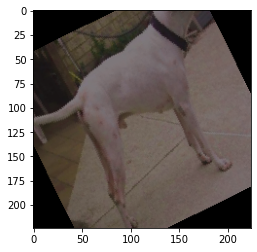

torch.Size([3, 224, 224])


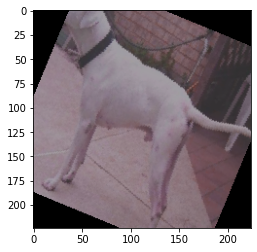

torch.Size([3, 224, 224])


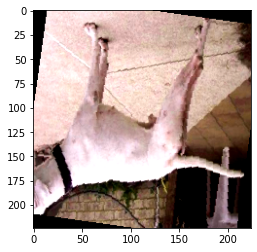

torch.Size([3, 224, 224])


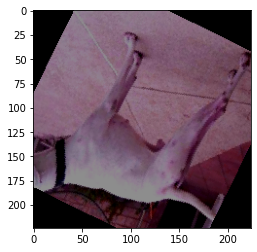

torch.Size([3, 224, 224])


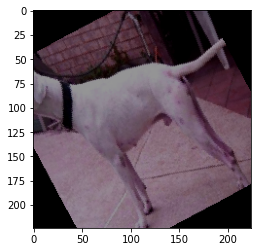

torch.Size([3, 224, 224])


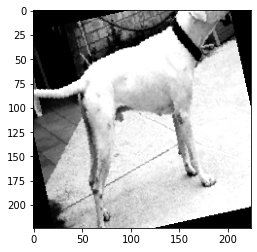

torch.Size([3, 224, 224])


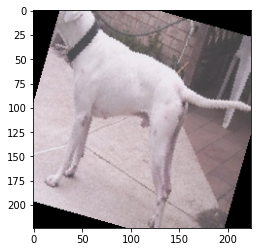

torch.Size([3, 224, 224])


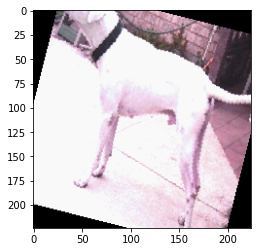

torch.Size([3, 224, 224])


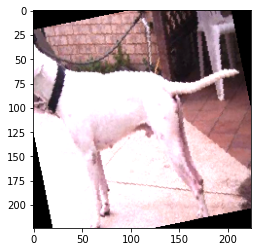

torch.Size([3, 224, 224])


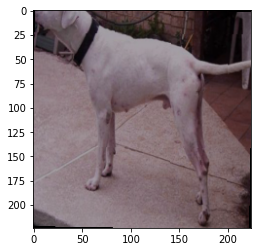

In [16]:
# Check transformed images
for _ in range(10):
    for idx, (img, label) in enumerate(dataset):
        if idx >= 1:
            break
        print(img.shape)
        plt.imshow(img.permute(1, 2, 0))
        plt.show()

In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [18]:
def save_checkpoint(state, filename=filename):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_acc = checkpoint['acc']

In [19]:
if load_model and os.path.exists(filename):
    load_checkpoint(torch.load(filename))
else:
    best_acc = 0

In [20]:
# Check accuracy on training and test to see how good our model
def check_accuracy(loader, model, test=True):
    if test:
        print('Checking accuracy on test data', end='')
    else:
        print('Checking accuracy on training data', end='')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)  # shape = batch_size x num_classes
            _, predictions = scores.max(dim=1)  # get index of max value
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        acc = float(num_correct) / float(num_samples) * 100
        #print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')

        model.train()
        return acc

In [21]:
# Unfreeze parameters and train again
# Empirically it is NOT BETTER for 5 epochs

# for param in model.parameters():
#     param.requires_grad = True

In [22]:
# Train network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to Cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward
        scores = model(data)  # shape batch_size x num_classes
        loss = criterion(scores, targets)
        losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()
    
    mean_loss = sum(losses)/len(losses)
    acc = check_accuracy(test_loader, model)
    print(f'\rLoss at epoch {epoch} is {mean_loss:.5f}. Accuracy is {acc:.2f}')

    if best_acc < acc:
        best_acc = acc
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'acc': best_acc}
        save_checkpoint(checkpoint)

Loss at epoch 0 is 0.21922. Accuracy is 94.48
=> Saving checkpoint
Loss at epoch 1 is 0.18136. Accuracy is 95.66
=> Saving checkpoint
Loss at epoch 2 is 0.17342. Accuracy is 95.56


In [23]:
# 2021.03.02 - best accuracy was 97.98 % - WITHOUT augmentation
# Usually augmented images need more epochs to train.
print(f': {check_accuracy(train_loader, model, test=False):.2f}')
print(f': {check_accuracy(test_loader, model):.2f}')

Checking accuracy on training data: 95.09
Checking accuracy on test data: 95.78
